In [1]:
# 忽略warnings
import warnings 
warnings.filterwarnings('ignore') 

import matplotlib.pyplot as plt
import numpy as np

# 导入util模块的各种方法
# from keras.utils.np_utils import to_categorical
# 导入数据集
from keras.datasets import imdb
# 导入模型、优化器、损失函数等等
from keras import regularizers
from keras import optimizers
from keras import metrics
from keras import models
from keras import losses
from keras import layers

Using TensorFlow backend.


# 04. 机器学习基础
学完第3章的三个实例，你应该已经知道如何用神经网络解决分类问题和回归问题，而且也看到了机器学习的核心难题：**过拟合**。本章会将你对这些问题的直觉固化为解决深度学习问题的可靠的概念框架。我们将把所有这些概念——**模型评估**、**数据预处理**、**特征工程**、**解决过拟合**——整合为详细的七步工作流程，用来解决任何机器学习任务。

## 4.1 机器学习的四个分支
机器学习算法大致可分为四大类，我们将在接下来的四小节中依次介绍。

### 4.1.1 监督学习
监督学习是目前最常见的机器学习类型。给定一组样本（通常由人工标注），它可以学会将输入数据映射到已知目标［也叫`标注`（annotation）］。本书前面的四个例子都属于监督学习。一般来说，近年来广受关注的深度学习应用几乎都属于监督学习，比如光学字符识别、语音识别、图像分类和语言翻译。

虽然监督学习主要包括`分类`和`回归`，但还有更多的奇特变体，主要包括如下几种：
+ 序列生成（sequence generation）。给定一张图像，预测描述图像的文字。序列生成有时可以被重新表示为一系列分类问题，比如反复预测序列中的单词或标记
+ 语法树预测（syntax tree prediction）。给定一个句子，预测其分解生成的语法树
+ 目标检测（object detection）。给定一张图像，在图中特定目标的周围画一个边界框。这个问题也可以表示为分类问题（给定多个候选边界框，对每个框内的目标进行分类）或分类与回归联合问题（用向量回归来预测边界框的坐标）
+ 图像分割（image segmentation）。给定一张图像，在特定物体上画一个像素级的掩模（mask）。

### 4.1.2 无监督学习
无监督学习是指在没有目标的情况下寻找输入数据的有趣变换，其目的在于数据可视化、数据压缩、数据去噪或更好地理解数据中的相关性。无监督学习是数据分析的必备技能，在解决监督学习问题之前，为了更好地了解数据集，它通常是一个必要步骤。`降维`（dimensionality reduction）和`聚类`（clustering）都是众所周知的无监督学习方法。

### 4.1.3 自监督学习
自监督学习是监督学习的一个特例，它与众不同，值得单独归为一类。自监督学习是没有人工标注的标签的监督学习，你可以将它看作没有人类参与的监督学习。标签仍然存在（因为总要有什么东西来监督学习过程），但它们是从输入数据中生成的，通常是使用启发式算法生成的。

举个例子，`自编码器`（autoencoder）是有名的自监督学习的例子，其生成的目标就是未经修改的输入。同样，给定视频中过去的帧来预测下一帧，或者给定文本中前面的词来预测下一个词，都是自监督学习的例子［这两个例子也属于`时序监督学习`（temporally supervised learning），即用未来的输入数据作为监督］。

> **注意**
> 
> 监督学习、自监督学习和无监督学习之间的区别有时很模糊，这三个类别更像是没有明确界限的连续体。自监督学习可以被重新解释为监督学习或无监督学习，这取决于你关注的是学习机制还是应用场景。
> 
> 本书的重点在于监督学习，因为它是当前深度学习的主要形式，行业应用非常广泛。后续章节也会简要介绍自监督学习。

### 4.1.4 强化学习
强化学习一直以来被人们所忽视，但最近随着Google的DeepMind公司将其成功应用于学习下围棋并达到最高水平，机器学习的这一分支开始受到大量关注。

在强化学习中，`智能体`（agent）接收有关其环境的信息，并学会选择使某种奖励最大化的行动。例如，神经网络会“观察”视频游戏的屏幕并输出游戏操作，目的是尽可能得高分，这种神经网络可以通过强化学习来训练。

目前，强化学习主要集中在研究领域，除游戏外还没有取得实践上的重大成功。但是，我们期待强化学习未来能够实现越来越多的实际应用：自动驾驶汽车、机器人、资源管理、教育等。强化学习的时代已经到来，或即将到来。

##### 分类和回归术语表
分类和回归都包含很多专业术语，这些术语在机器学习领域都有确切的定义，你应该了解这些定义：
+ **样本**（sample）或**输入**（input）：进入模型的数据点
+ **预测**（prediction）或**输出**（output）：从模型出来的结果
+ **目标**（target）：真实值。对于外部数据源，理想情况下，模型应该能够预测出目标
+ **预测误差**（prediction error）或**损失值**（loss value）：模型预测与目标之间的距离
+ **类别**（class）：分类问题中供选择的一组标签。例如，对猫狗图像进行分类时，“狗”和“猫”就是两个类别
+ **标签**（label）：分类问题中类别标注的具体例子。比如，如果1234号图像被标注为包含类别“狗”，那么“狗”就是 1234 号图像的标签。
+ **真值**（ground-truth）或**标注**（annotation）：数据集的所有目标，通常由人工收集
+ **二分类**（binary classification）：一种分类任务，每个输入样本都应被划分到两个互斥的类别中
+ **多分类**（multiclass classification）：一种分类任务，每个输入样本都应被划分到两个以上的类别中，比如手写数字分类
+ **多标签分类**（multilabel classification）：一种分类任务，每个输入样本都可以分配多个标签。举个例子，如果一幅图像里可能既有猫又有狗，那么应该同时标注“猫”标签和“狗”标签。每幅图像的标签个数通常是可变的
+ **标量回归**（scalar regression）：目标是连续标量值的任务。预测房价就是一个很好的例子，不同的目标价格形成一个连续的空间
+ **向量回归**（vector regression）：目标是一组连续值（比如一个连续向量）的任务。如果对多个值（比如图像边界框的坐标）进行回归，那就是向量回归
+ **小批量**（mini-batch）或**批量**（batch）：模型同时处理的一小部分样本（样本数通常为8~128）。样本数通常取2的幂，这样便于GPU上的内存分配。训练时，小批量用来为模型权重计算一次梯度下降更新

## 4.2 评估机器学习模型
机器学习的目的是得到可以`泛化`（generalize）的模型，即在前所未见的数据上表现很好的模型，而过拟合则是核心难点。你只能控制可以观察的事情，所以能够可靠地衡量模型的泛化能力非常重要。后面几节将介绍降低过拟合以及将泛化能力最大化的方法。本节重点介绍如何衡量泛化能力，即如何评估机器学习模型。

### 4.2.1 训练集、验证集和测试集

评估模型的重点是将数据划分为三个集合：训练集、验证集和测试集。在训练数据上训练模型，在验证数据上评估模型。一旦找到了最佳参数，就在测试数据上最后测试一次。

你可能会问，为什么不是两个集合：一个训练集和一个测试集？在训练集上训练模型，然后在测试集上评估模型。这样简单得多！

原因在于开发模型时总是需要调节模型配置，比如选择层数或每层大小［这叫作模型的`超参数`（hyperparameter），以便与`模型参数`（即权重）区分开］。这个调节过程需要使用模型在验证数据上的性能作为反馈信号。这个调节过程本质上就是一种学习：在某个参数空间中寻找良好的模型配置。因此，如果基于模型在验证集上的性能来调节模型配置，会很快导致模型在验证集上过拟合，即使你并没有在验证集上直接训练模型也会如此。

最后，你得到的模型在验证集上的性能非常好（人为造成的），因为这正是你优化的目的。你关心的是模型在全新数据上的性能，因此你需要使用一个完全不同的、前所未见的数据集来评估模型，它就是测试集。

将数据划分为训练集、验证集和测试集可能看起来很简单，但如果可用数据很少，还有几种高级方法可以派上用场。我们先来介绍三种经典的评估方法：
+ 简单的留出验证
+ K折验证
+ 带有打乱数据的重复 K 折验证

##### 简单的留出验证
留出一定比例的数据作为测试集。在剩余的数据上训练模型，然后在测试集上评估模型。

下面代码给出了其简单实现：
```python
num_validation_samples = 10000
# 通常需要打乱数据
np.random.shuffle(data) 
# 定义验证集
validation_data = data[:num_validation_samples]
data = data[num_validation_samples:]
# 定义训练集
training_data = data[:] 
# 在训练数据上训练模型，并在验证数据上评估模型
model = get_model() 
model.train(training_data)                          
validation_score = model.evaluate(validation_data)  
# 现在你可以调节模型、重新训练、评估，然后再次调节……
# 一旦调节好超参数，通常就在所有非测试数据上从头开始训练最终模型
model = get_model()
model.train(np.concatenate([training_data, validation_data]))   
test_score = model.evaluate(test_data)    
```

这是最简单的评估方法，但有一个缺点：如果可用的数据很少，那么可能验证集和测试集包含的样本就太少，从而无法在统计学上代表数据。这个问题很容易发现：如果在划分数据前进行不同的随机打乱，最终得到的模型性能差别很大，那么就存在这个问题。接下来会介绍K折验证与重复的K折验证，它们是解决这一问题的两种方法。

##### K折验证
K折验证将数据划分为大小相同的`K`个分区。对于每个分区`i`，在剩余的`K-1`个分区上训练模型，然后在分区`i`上评估模型。最终分数等于`K`个分数的平均值。与留出验证一样，这种方法也需要独立的验证集进行模型校正。

K折交叉验证的简单实现：
```python
k = 4
num_validation_samples = len(data) // k
np.random.shuffle(data)
validation_scores = []
for fold in range(k):
    # 选择验证数据分区
    validation_data = data[num_validation_samples * fold:num_validation_samples * (fold + 1)]           
    # 使用剩余数据作为训练数据。注意，+ 运算符是列表合并，不是求和
    training_data = data[:num_validation_samples * fold] + data[num_validation_samples * (fold + 1):]
    # 创建一个全新的模型实例（未训练）
    model = get_model()
    model.train(training_data)
    validation_score = model.evaluate(validation_data)
    validation_scores.append(validation_score)

# 最终验证分数：K 折验证分数的平均值
validation_score = np.average(validation_scores) 
# 在所有非测试数据上训练最终模型　
model = get_model() 
model.train(data)                        
test_score = model.evaluate(test_data)   
```

##### 带有打乱数据的重复K折验证
如果可用的数据相对较少，而你又需要尽可能精确地评估模型，那么可以选择`带有打乱数据的重复K折验证`（iterated K-fold validation with shuffling）。具体做法是多次使用K折验证，在每次将数据划分为`K`个分区之前都先将数据打乱。最终分数是每次K折验证分数的平均值。注意，这种方法一共要训练和评估$P \times K$个模型（P是重复次数），计算代价很大。

### 4.2.2 评估模型的注意事项
选择模型评估方法时，需要注意以下几点：
+ **数据代表性**（data representativeness）：你希望训练集和测试集都能够代表当前数据。例如，你想要对数字图像进行分类，而图像样本是按类别排序的，如果你将前`80%`作为训练集，剩余`20%`作为测试集，那么会导致训练集中只包含类别`0~7`，而测试集中只包含类别`8~9`。这个错误看起来很可笑，却很常见。因此，在将数据划分为训练集和测试集之前，通常应该随机打乱数据
+ **时间箭头**（the arrow of time）：如果想要根据过去预测未来（比如明天的天气、股票走势等），那么在划分数据前你不应该随机打乱数据，因为这么做会造成时间泄露，你的模型将在未来数据上得到有效训练。在这种情况下，你应该始终确保测试集中所有数据的时间都晚于训练集数据
+ **数据冗余**（redundancy in your data）：如果数据中的某些数据点出现了两次（这在现实中的数据里十分常见），那么打乱数据并划分成训练集和验证集会导致训练集和验证集之间的数据冗余。从效果上来看，你是在部分训练数据上评估模型，这是极其糟糕的！一定要确保训练集和验证集之间没有交集

## 4.3 数据预处理、特征工程和特征学习
许多数据预处理方法和特征工程技术都是和特定领域相关的（比如只和文本数据或图像数据相关），我们将在后续章节的实例中介绍这些内容。现在我们要介绍所有数据领域通用的基本方法。

### 4.3.1　神经网络的数据预处理
数据预处理的目的是使原始数据更适于用神经网络处理，包括向量化、标准化、处理缺失值和特征提取。

##### 1.向量化
神经网络的所有输入和目标都必须是浮点数张量（在特定情况下可以是整数张量）。无论处理什么数据（声音、图像还是文本），都必须首先将其转换为张量，这一步叫作`数据向量化`（data vectorization）。例如，在前面两个文本分类的例子中，开始时文本都表示为整数列表（代表单词序列），然后我们用`one-hot`编码将其转换为`float32`格式的张量。在手写数字分类和预测房价的例子中，数据已经是向量形式，所以可以跳过这一步

##### 2.值标准化
在手写数字分类的例子中，开始时图像数据被编码为`0~255`范围内的整数，表示灰度值。将这一数据输入网络之前，你需要将其转换为`0~1`范围内的浮点数。同样，预测房价时，特征有各种不同的取值范围，有些特征是较小的浮点数，有些特征是相对较大的整数。将这一数据输入网络之前，需要对每个特征做标准化，使其均值为0、标准差为1。

一般来说，将取值相对较大的数据（比如多位整数，比网络权重的初始值大很多）或异质数据（比如数据的一个特征在`0~1`范围内，另一个特征在`100~200`范围内）输入到神经网络中是不安全的。这么做可能导致较大的梯度更新，进而导致网络无法收敛。为了让网络的学习变得更容易，输入数据应该具有以下特征：
+ 取值较小：大部分值都应该在 0~1 范围内
+ 同质性（homogenous）：所有特征的取值都应该在大致相同的范围内

此外，下面这种更严格的标准化方法也很常见，而且很有用，虽然不一定总是必需的（例如，对于数字分类问题就不需要这么做）：
+ 将每个特征分别标准化，使其平均值为0
+ 将每个特征分别标准化，使其标准差为1

##### 3.处理缺失值
你的数据中有时可能会有缺失值。例如在房价的例子中，第一个特征是人均犯罪率。如果不是所有样本都具有这个特征的话，怎么办？

一般来说，对于神经网络，将缺失值设置为`0`是安全的，只要`0`不是一个有意义的值。网络能够从数据中学到`0`意味着缺失数据，并且会忽略这个值。

**注意**，如果测试数据中可能有缺失值，而网络是在没有缺失值的数据上训练的，那么网络不可能学会忽略缺失值。在这种情况下，你应该人为生成一些有缺失项的训练样本：多次复制一些训练样本，然后删除测试数据中可能缺失的某些特征。

### 4.3.2 特征工程
`特征工程`（feature engineering）是指将数据输入模型之前，利用你自己关于数据和机器学习算法（这里指神经网络）的知识对数据进行硬编码的变换（不是模型学到的），以改善模型的效果。多数情况下，一个机器学习模型无法从完全任意的数据中进行学习。呈现给模型的数据应该便于模型进行学习。

我们来看一个直观的例子。假设你想开发一个模型，输入一个时钟图像，模型能够输出对应的时间：

<img src="images/04_03.png" style="width:400px;"/>

如果你选择用图像的原始像素作为输入数据，那么这个机器学习问题将非常困难。你需要用卷积神经网络来解决这个问题，而且还需要花费大量的计算资源来训练网络。

但如果你从更高的层次理解了这个问题（你知道人们怎么看时钟上的时间），那么可以为机器学习算法找到更好的输入特征，比如找到时钟指针对应的黑色像素并输出每个指针尖的$(x, y)$坐标，然后，一个简单的机器学习算法就可以学会这些坐标与时间的对应关系。

你还可以进一步思考：进行坐标变换，将$(x, y)$坐标转换为相对于图像中心的极坐标。这样输入就变成了每个时钟指针的角度$\theta$。现在的特征使问题变得非常简单，根本不需要机器学习，因为简单的舍入运算和字典查找就足以给出大致的时间。

**这就是特征工程的本质：用更简单的方式表述问题，从而使问题变得更容易。它通常需要深入理解问题。**

**深度学习出现之前，特征工程曾经非常重要，因为经典的浅层算法没有足够大的假设空间来自己学习有用的表示。将数据呈现给算法的方式对解决问题至关重要**。

例如，卷积神经网络在MNIST数字分类问题上取得成功之前，其解决方法通常是基于硬编码的特征，比如数字图像中的圆圈个数、图像中每个数字的高度、像素值的直方图等。对于现代深度学习，大部分特征工程都是不需要的，因为神经网络能够从原始数据中自动提取有用的特征。

这是否意味着，只要使用深度神经网络，就无须担心特征工程呢？并不是这样，原因有两点：
+ 良好的特征仍然可以让你用更少的资源更优雅地解决问题。例如，使用卷积神经网络来读取钟面上的时间是非常可笑的
+ 良好的特征可以让你用更少的数据解决问题。深度学习模型自主学习特征的能力依赖于大量的训练数据。如果只有很少的样本，那么特征的信息价值就变得非常重要

## 4.4 过拟合与欠拟合
过拟合存在于所有机器学习问题中。学会如何处理过拟合对掌握机器学习至关重要。

机器学习的根本问题是`优化`和`泛化`之间的对立：
+ 优化（optimization）是指调节模型以在训练数据上得到最佳性能（即机器学习中的学习）
+ 泛化（generalization）是指训练好的模型在前所未见的数据上的性能好坏

机器学习的目的当然是得到良好的`泛化`，但你无法控制`泛化`，只能基于训练数据调节模型。

训练开始时，`优化`和`泛化`是相关的：训练数据上的损失越小，测试数据上的损失也越小。这时的模型是`欠拟合`（underfit）的。但在训练数据上迭代一定次数之后，`泛化`不再提高，验证指标先是不变，然后开始变差，即模型开始`过拟合`。这时模型开始学习仅和训练数据有关的模式，但这种模式对新数据来说是错误的或无关紧要的。

为了防止模型从训练数据中学到错误或无关紧要的模式，最优解决方法是获取更多的训练数据。模型的训练数据越多，泛化能力自然也越好。如果无法获取更多数据，次优解决方法是调节模型允许存储的信息量，或对模型允许存储的信息加以约束。如果一个网络只能记住几个模式，那么优化过程会迫使模型集中学习最重要的模式，这样更可能得到良好的泛化。

这种降低过拟合的方法叫作`正则化`（regularization）。

我们先介绍几种最常见的正则化方法，然后将其应用于实践中，以改进`3.4`节的电影分类模型。

### 4.4.1 减小网络大小
防止过拟合的最简单的方法就是减小模型大小，即减少模型中可学习参数的个数（这由层数和每层的单元个数决定）。在深度学习中，模型中可学习参数的个数通常被称为模型的`容量`（capacity）。直观上来看，参数更多的模型拥有更大的`记忆容量`（memorization capacity），因此能够在训练样本和目标之间轻松地学会完美的字典式映射，这种映射没有任何泛化能力。例如，拥有500000个二进制参数的模型，能够轻松学会`MNIST`训练集中所有数字对应的类别——我们只需让50000个数字每个都对应10个二进制参数。但这种模型对于新数字样本的分类毫无用处。始终牢记：深度学习模型通常都很擅长拟合训练数据，但真正的挑战在于泛化，而不是拟合。

与此相反，如果网络的记忆资源有限，则无法轻松学会这种映射。因此，为了让损失最小化，网络必须学会对目标具有很强预测能力的压缩表示，这也正是我们感兴趣的数据表示。同时请记住，你使用的模型应该具有足够多的参数，以防欠拟合，即模型应避免记忆资源不足。在容量过大与容量不足之间要找到一个折中。

不幸的是，没有一个魔法公式能够确定最佳层数或每层的最佳大小。你必须评估一系列不同的网络架构，以便为数据找到最佳的模型大小。要找到合适的模型大小，一般的工作流程是开始时选择相对较少的层和参数，然后逐渐增加层的大小或增加新层，直到这种增加对验证损失的影响变得很小。

我们在电影评论分类的网络上试一下。首先加载数据集并向量化：

In [2]:
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

def vectorize_sequences(sequences, dimension=10000):
    # Create an all-zero matrix of shape (len(sequences), dimension)
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.  # set specific indices of results[i] to 1s
    return results

# Our vectorized training data
x_train = vectorize_sequences(train_data)
# Our vectorized test data
x_test = vectorize_sequences(test_data)
# Our vectorized labels
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

原始模型：

In [3]:
original_model = models.Sequential()
original_model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
original_model.add(layers.Dense(16, activation='relu'))
original_model.add(layers.Dense(1, activation='sigmoid'))

original_model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
original_hist = original_model.fit(x_train, y_train, epochs=20, batch_size=512, validation_data=(x_test, y_test))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
25000/25000 [==============================] - 4s 172us/step - loss: 0.4981 - acc: 0.7974 - val_loss: 0.3720 - val_acc: 0.8803
Epoch 2/20
25000/25000 [==============================] - 4s 156us/step - loss: 0.2870 - acc: 0.9062 - val_loss: 0.3011 - val_acc: 0.8877
Epoch 3/20
25000/25000 [==============================] - 4s 152us/step - loss: 0.2110 - acc: 0.9288 - val_loss: 0.3119 - val_acc: 0.8746
Epoch 4/20
25000/25000 [==============================] - 3s 139us/step - loss: 0.1765 - acc: 0.9380 - val_loss: 0.2909 - val_acc: 0.8850
Epoch 5/20
25000/25000 [==============================] - 4s 147us/step - loss: 0.1499 - acc: 0.9484 - val_loss: 0.3050 - val_acc: 0.8802
Epoch 6/20
25000/25000 [==============================] - 4s 142us/step - loss: 0.1300 - acc: 0.9560 - val_loss: 0.3295 - val_acc: 0.8766
Epoch 7/20
25000/25000 [===

更小的模型：

In [4]:
smaller_model = models.Sequential()
smaller_model.add(layers.Dense(4, activation='relu', input_shape=(10000,)))
smaller_model.add(layers.Dense(4, activation='relu'))
smaller_model.add(layers.Dense(1, activation='sigmoid'))

smaller_model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
smaller_model_hist = smaller_model.fit(x_train, y_train, epochs=20, batch_size=512, validation_data=(x_test, y_test))

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
25000/25000 [==============================] - 4s 144us/step - loss: 0.6171 - acc: 0.7754 - val_loss: 0.5472 - val_acc: 0.8444
Epoch 2/20
25000/25000 [==============================] - 4s 145us/step - loss: 0.4679 - acc: 0.8740 - val_loss: 0.4314 - val_acc: 0.8698
Epoch 3/20
25000/25000 [==============================] - 3s 137us/step - loss: 0.3593 - acc: 0.8942 - val_loss: 0.3558 - val_acc: 0.8806
Epoch 4/20
25000/25000 [==============================] - 3s 121us/step - loss: 0.2887 - acc: 0.9084 - val_loss: 0.3220 - val_acc: 0.8796
Epoch 5/20
25000/25000 [==============================] - 3s 136us/step - loss: 0.2438 - acc: 0.9197 - val_loss: 0.2955 - val_acc: 0.8866
Epoch 6/20
25000/25000 [==============================] - 3s 137us/step - loss: 0.2135 - acc: 0.9274 - val_loss: 0.2819 - val_acc: 0.8908
Epoch 7/20
25000/25000 [==============================] - 3s 130us/step - loss: 0.1913 - acc: 0.9341 - val_loss: 0.2790 - 

比较了原始网络与更小网络的验证损失。圆点是更小网络的验证损失值，十字是原始网络的验证损失值，更小的验证损失对应更好的模型。

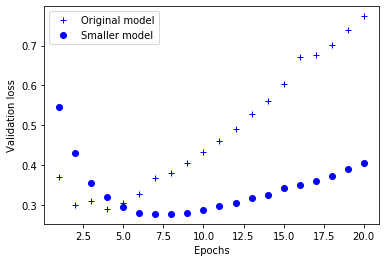

In [5]:
epochs = range(1, 21)
original_val_loss = original_hist.history['val_loss']
smaller_model_val_loss = smaller_model_hist.history['val_loss']

# b+ is for "blue cross"
plt.plot(epochs, original_val_loss, 'b+', label='Original model')
# "bo" is for "blue dot"
plt.plot(epochs, smaller_model_val_loss, 'bo', label='Smaller model')
plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.legend()
plt.show()

如你所见，更小的网络开始过拟合的时间要晚于参考网络（前者6轮后开始过拟合，而后者4轮后开始），而且开始过拟合之后，它的性能变差的速度也更慢。

我们再向这个基准中添加一个容量更大的网络（容量远大于问题所需）。

In [6]:
bigger_model = models.Sequential()
bigger_model.add(layers.Dense(512, activation='relu', input_shape=(10000,)))
bigger_model.add(layers.Dense(512, activation='relu'))
bigger_model.add(layers.Dense(1, activation='sigmoid'))

bigger_model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
bigger_model_hist = bigger_model.fit(x_train, y_train, epochs=20, batch_size=512, validation_data=(x_test, y_test))

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
25000/25000 [==============================] - 12s 474us/step - loss: 0.4612 - acc: 0.7932 - val_loss: 0.3234 - val_acc: 0.8634
Epoch 2/20
25000/25000 [==============================] - 11s 439us/step - loss: 0.2202 - acc: 0.9144 - val_loss: 0.2923 - val_acc: 0.8799
Epoch 3/20
25000/25000 [==============================] - 11s 437us/step - loss: 0.1249 - acc: 0.9539 - val_loss: 0.3318 - val_acc: 0.8810
Epoch 4/20
25000/25000 [==============================] - 11s 448us/step - loss: 0.0741 - acc: 0.9810 - val_loss: 0.4836 - val_acc: 0.8666
Epoch 5/20
25000/25000 [==============================] - 11s 445us/step - loss: 0.0845 - acc: 0.9873 - val_loss: 0.4823 - val_acc: 0.8821
Epoch 6/20
25000/25000 [==============================] - 11s 437us/step - loss: 0.0032 - acc: 0.9995 - val_loss: 4.3444 - val_acc: 0.6264
Epoch 7/20
25000/25000 [==============================] - 11s 431us/step - loss: 0.0781 - acc: 0.9896 - val_loss: 0.

比较更大的网络与参考网络的性能：

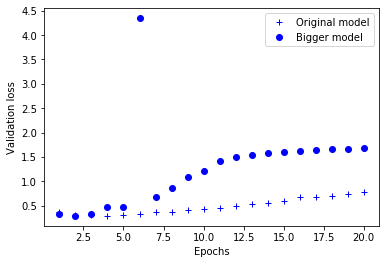

In [7]:
bigger_model_val_loss = bigger_model_hist.history['val_loss']
plt.plot(epochs, original_val_loss, 'b+', label='Original model')
plt.plot(epochs, bigger_model_val_loss, 'bo', label='Bigger model')
plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.legend()
plt.show()

更大的网络只过了一轮就开始过拟合，过拟合也更严重。其验证损失的波动也更大。

下图同时给出了这两个网络的训练损失。如你所见，更大网络的训练损失很快就接近于零。网络的容量越大，它拟合训练数据的速度就越快，也更容易过拟合。

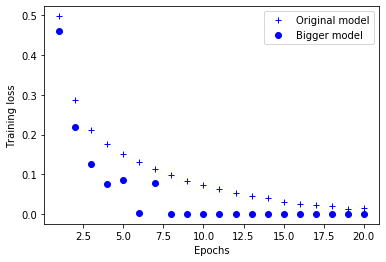

In [8]:
original_train_loss = original_hist.history['loss']
bigger_model_train_loss = bigger_model_hist.history['loss']

plt.plot(epochs, original_train_loss, 'b+', label='Original model')
plt.plot(epochs, bigger_model_train_loss, 'bo', label='Bigger model')
plt.xlabel('Epochs')
plt.ylabel('Training loss')
plt.legend()
plt.show()

### 4.4.2 添加权重正则化
你可能知道奥卡姆剃刀原理：如果一件事情有两种解释，那么最可能正确的解释就是最简单的那个，即假设更少的那个。这个原理也适用于神经网络学到的模型：给定一些训练数据和一种网络架构，很多组权重值（即很多模型）都可以解释这些数据。简单模型比复杂模型更不容易过拟合。

这里的`简单模型`是指参数值分布的熵更小的模型（或参数更少的模型，比如上一节的例子）。因此，一种常见的降低过拟合的方法就是强制让模型权重只能取较小的值，从而限制模型的复杂度，这使得权重值的分布更加`规则`（regular）。这种方法叫作`权重正则化`（weight regularization），其实现方法是向网络损失函数中添加与较大权重值相关的成本。这个成本有两种形式：
+ **L1正则化**：添加的成本与权重系数的绝对值（即权重的L1范数）成正比。
+ **L2正则化**：添加的成本与权重系数的平方（权重的L2范数）成正比。神经网络的L2正则化也叫`权重衰减`（weight decay）。不要被不同的名称搞混，权重衰减与L2正则化在数学上是完全相同的

在`Keras`中，添加权重正则化的方法是向层传递权重正则化项实例作为关键字参数。下列代码将向电影评论分类网络中添加L2权重正则化。

In [9]:
l2_model = models.Sequential()
l2_model.add(layers.Dense(16, kernel_regularizer=regularizers.l2(0.001), activation='relu', input_shape=(10000,)))
l2_model.add(layers.Dense(16, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
l2_model.add(layers.Dense(1, activation='sigmoid'))
l2_model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
l2_model_hist = l2_model.fit(x_train, y_train, epochs=20, batch_size=512, validation_data=(x_test, y_test))

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
25000/25000 [==============================] - 3s 123us/step - loss: 0.5494 - acc: 0.7978 - val_loss: 0.4345 - val_acc: 0.8644
Epoch 2/20
25000/25000 [==============================] - 3s 117us/step - loss: 0.3569 - acc: 0.9009 - val_loss: 0.3553 - val_acc: 0.8848
Epoch 3/20
25000/25000 [==============================] - 3s 116us/step - loss: 0.2933 - acc: 0.9156 - val_loss: 0.3340 - val_acc: 0.8881
Epoch 4/20
25000/25000 [==============================] - 3s 115us/step - loss: 0.2664 - acc: 0.9242 - val_loss: 0.3344 - val_acc: 0.8877
Epoch 5/20
25000/25000 [==============================] - 3s 116us/step - loss: 0.2495 - acc: 0.9294 - val_loss: 0.3485 - val_acc: 0.8802
Epoch 6/20
25000/25000 [==============================] - 3s 134us/step - loss: 0.2390 - acc: 0.9340 - val_loss: 0.3591 - val_acc: 0.8774
Epoch 7/20
25000/25000 [==============================] - 3s 117us/step - loss: 0.2307 - acc: 0.9375 - val_loss: 0.3446 - 

`l2(0.001)`的意思是该层权重矩阵的每个系数都会使网络总损失增加`0.001 * weight_coefficient_value`。**注意**，由于这个惩罚项只在训练时添加，所以这个网络的训练损失会比测试损失大很多。

下图显示了`L2正则化`惩罚的影响，即使两个模型的参数个数相同，具有`L2正则化`的模型更不容易过拟合。

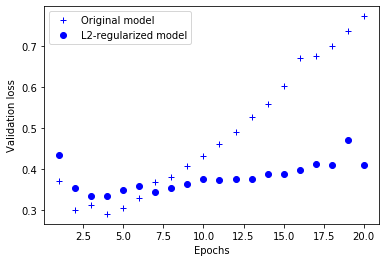

In [10]:
l2_model_val_loss = l2_model_hist.history['val_loss']

plt.plot(epochs, original_val_loss, 'b+', label='Original model')
plt.plot(epochs, l2_model_val_loss, 'bo', label='L2-regularized model')
plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.legend()

plt.show()

你还可以用`Keras`中以下这些权重正则化项来代替`L2正则化`：
```python
# L1正则化
regularizers.l1(0.001) 
# 同时做L1和L2正则化
regularizers.l1_l2(l1=0.001, l2=0.001)
```

### 4.4.3 添加dropout正则化
`dropout`是神经网络最有效也最常用的正则化方法之一，它是由多伦多大学的`Geoffrey Hinton`和他的学生开发的。对某一层使用`dropout`，就是在训练过程中随机将该层的一些输出特征舍弃（设置为0）。

假设在训练过程中，某一层对给定输入样本的返回值应该是向量`[0.2, 0.5, 1.3, 0.8, 1.1]`。使用`dropout`后，这个向量会有几个随机的元素变成0，比如`[0, 0.5, 1.3, 0, 1.1]`。`dropout比率`是被设为0的特征所占的比例，通常在`0.2~0.5`范围内。测试时没有单元被舍弃，而该层的输出值需要按`dropout`比率缩小，因为这时比训练时有更多的单元被激活，需要加以平衡。

假设有一个包含某层输出的`Numpy`矩阵`layer_output`，其形状为`(batch_size, features)`。训练时，我们随机将矩阵中一部分值设为0：
```python
layer_output *= np.random.randint(0, high=2, size=layer_output.shape)
```

测试时，我们将输出按`dropout`比率缩小。这里我们乘以`0.5`（因为前面舍弃了一半的单元）：
```python
layer_output *= 0.5
```

注意，为了实现这一过程，还可以让两个运算都在训练时进行，而测试时输出保持不变：
```python
# 训练时
layer_output *= np.random.randint(0, high=2, size=layer_output.shape)
# 注意，是成比例放大而不是成比例缩小
layer_output /= 0.5
```

这通常也是实践中的实现方式（见`图4-8`）。

<img src="images/04_08.png" style="width:600px;"/>

这一方法可能看起来有些奇怪和随意。它为什么能够降低过拟合？`Geoffrey Hinton`说他的灵感之一来自于银行的防欺诈机制。用他自己的话来说：“我去银行办理业务。柜员不停地换人，于是我问其中一人这是为什么。他说他不知道，但他们经常换来换去。我猜想，银行工作人员要想成功欺诈银行，他们之间要互相合作才行。这让我意识到，在每个样本中随机删除不同的部分神经元，可以阻止它们的阴谋，因此可以降低过拟合。”

其核心思想是在层的输出值中引入噪声，打破不显著的偶然模式。如果没有噪声的话，网络将会记住这些偶然模式。

> 参见Reddit网站上的讨论“AMA: We are the Google Brain team. We'd love to answer your questions about machine learning”

在`Keras`中，你可以通过`Dropout`层向网络中引入`dropout`，`dropout`将被应用于前面一层的输出。

In [11]:
dpt_model = models.Sequential()
dpt_model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
dpt_model.add(layers.Dropout(0.5))
dpt_model.add(layers.Dense(16, activation='relu'))
dpt_model.add(layers.Dropout(0.5))
dpt_model.add(layers.Dense(1, activation='sigmoid'))

dpt_model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
dpt_model_hist = dpt_model.fit(x_train, y_train, epochs=20, batch_size=512, validation_data=(x_test, y_test))

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
25000/25000 [==============================] - 1154s 46ms/step - loss: 0.5912 - acc: 0.6847 - val_loss: 0.4401 - val_acc: 0.8557
Epoch 2/20
25000/25000 [==============================] - 4s 169us/step - loss: 0.4353 - acc: 0.8141 - val_loss: 0.3342 - val_acc: 0.8800
Epoch 3/20
25000/25000 [==============================] - 4s 151us/step - loss: 0.3474 - acc: 0.8614 - val_loss: 0.2877 - val_acc: 0.8875
Epoch 4/20
25000/25000 [==============================] - 4s 142us/step - loss: 0.3053 - acc: 0.8846 - val_loss: 0.2753 - val_acc: 0.8904
Epoch 5/20
25000/25000 [==============================] - 4s 151us/step - loss: 0.2637 - acc: 0.9022 - val_loss: 0.2794 - val_acc: 0.8899
Epoch 6/20
25000/25000 [==============================] - 4s 142us/step - loss: 0.2350 - acc: 0.9152 - val_loss: 0.2897 - val_acc: 0.8860
Epoch 7/20
25000/25000 [==============================] - 3s 133us/step - loss: 0.2152 - acc: 0.9231 - val_loss: 0.3030 

比较`dropout`模型和参考网络：

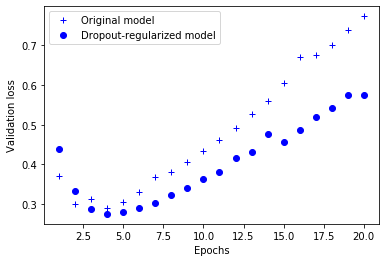

In [12]:
dpt_model_val_loss = dpt_model_hist.history['val_loss']

plt.plot(epochs, original_val_loss, 'b+', label='Original model')
plt.plot(epochs, dpt_model_val_loss, 'bo', label='Dropout-regularized model')
plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.legend()
plt.show()

总结一下，防止神经网络过拟合的常用方法包括：
+ 获取更多的训练数据 
+ 减小网络容量
+ 添加权重正则化
+ 添加dropout


## 4.5 机器学习的通用工作流程
本节将介绍一种可用于解决任何机器学习问题的通用模板。这一模板将你在本章学到的这些概念串在一起：问题定义、评估、特征工程和解决过拟合。

### 4.5.1 定义问题，收集数据集
首先，你必须定义所面对的问题：
+ 你的输入数据是什么？你要预测什么？只有拥有可用的训练数据，你才能学习预测某件事情。比如，只有同时拥有电影评论和情感标注，你才能学习对电影评论进行情感分类。因此，数据可用性通常是这一阶段的限制因素
+ 你面对的是什么类型的问题？是二分类问题、多分类问题、标量回归问题、向量回归问题，还是多分类、多标签问题？或者是其他问题，比如聚类、生成或强化学习？确定问题类型有助于你选择模型架构、损失函数等

只有明确了输入、输出以及所使用的数据，你才能进入下一阶段。注意你在这一阶段所做的假设：
+ 假设输出是可以根据输入进行预测的
+ 假设可用数据包含足够多的信息，足以学习输入和输出之间的关系

在开发出工作模型之前，这些只是假设，等待验证真假。并非所有问题都可以解决。你收集了包含输入$X$和目标$Y$的很多样例，并不意味着$X$包含足够多的信息来预测$Y$。例如，如果你想根据某支股票最近的历史价格来预测其股价走势，那你成功的可能性不大，因为历史价格并没有包含很多可用于预测的信息。

有一类无法解决的问题你应该知道，那就是`非平稳问题`（nonstationary problem）。假设你想要构建一个服装推荐引擎，并在一个月（八月）的数据上训练，然后在冬天开始生成推荐结果。一个大问题是，人们购买服装的种类是随着季节变化的，即服装购买在几个月的尺度上是一个非平稳现象。你想要建模的对象随着时间推移而改变。在这种情况下，正确的做法是不断地利用最新数据重新训练模型，或者在一个问题是平稳的时间尺度上收集数据。对于服装购买这种周期性问题，几年的数据足以捕捉到季节性变化，但一定要记住，要将一年中的时间作为模型的一个输入。

请记住，**机器学习只能用来记忆训练数据中存在的模式**。你只能识别出曾经见过的东西。在过去的数据上训练机器学习来预测未来，这里存在一个假设，就是未来的规律与过去相同。但事实往往并非如此。

### 4.5.2 选择衡量成功的指标
要控制一件事物，就需要能够观察它。要取得成功，就必须给出成功的定义：精度？准确率（precision）和召回率（recall）？客户保留率？衡量成功的指标将指引你选择损失函数，即模型要优化什么。它应该直接与你的目标（如业务成功）保持一致。

对于平衡分类问题（每个类别的可能性相同），`精度`和`接收者操作特征曲线下面积`（area under the receiver operating characteristic curve，ROC AUC）是常用的指标。对于类别不平衡的问题，你可以使用`准确率`和`召回率`。对于排序问题或多标签分类，你可以使用`平均准确率均值`（mean average precision）。自定义衡量成功的指标也很常见。

要想了解各种机器学习的成功衡量指标以及这些指标与不同问题域的关系，你可以浏览Kaggle网站上的数据科学竞赛，上面展示了各种各样的问题和评估指标。

### 4.5.3 确定评估方法
一旦明确了目标，你必须确定如何衡量当前的进展。前面介绍了三种常见的评估方法。
+ 留出验证集。数据量很大时可以采用这种方法
+ K折交叉验证。如果留出验证的样本量太少，无法保证可靠性，那么应该选择这种方法
+ 重复的K折验证。如果可用的数据很少，同时模型评估又需要非常准确，那么应该使用这种方法。

只需选择三者之一。大多数情况下，第一种方法足以满足要求。

### 4.5.4 准备数据
一旦知道了要训练什么、要优化什么以及评估方法，那么你就几乎已经准备好训练模型了。但首先你应该将数据格式化，使其可以输入到机器学习模型中（这里假设模型为深度神经网络）：
+ 如前所述，应该将数据格式化为张量
+ 这些张量的取值通常应该缩放为较小的值，比如在`[-1, 1]`区间或`[0, 1]`区间
+ 如果不同的特征具有不同的取值范围（异质数据），那么应该做数据标准化
+ 你可能需要做特征工程，尤其是对于小数据问题

准备好输入数据和目标数据的张量后，你就可以开始训练模型了。

### 4.5.5 开发比基准更好的模型
这一阶段的目标是获得`统计功效`（statistical power），即开发一个小型模型，它能够打败纯随机的基准（dumb baseline）。在`MNIST`数字分类的例子中，任何精度大于0.1的模型都可以说具有统计功效；在`IMDB`的例子中，任何精度大于0.5的模型都可以说具有统计功效。

注意，不一定总是能获得统计功效。如果你尝试了多种合理架构之后仍然无法打败随机基准，那么原因可能是问题的答案并不在输入数据中。要记住你所做的两个假设：
+ 假设输出是可以根据输入进行预测的
+ 假设可用的数据包含足够多的信息，足以学习输入和输出之间的关系

这些假设很可能是错误的，这样的话你需要从头重新开始。

如果一切顺利，你还需要选择三个关键参数来构建第一个工作模型：
+ 最后一层的激活。它对网络输出进行有效的限制。例如，`IMDB`分类的例子在最后一层使用了`sigmoid`，回归的例子在最后一层没有使用激活，等等
+ 损失函数。它应该匹配你要解决的问题的类型。例如，`IMDB`的例子使用`binary_crossentropy`、回归的例子使用`mse`，等等
+ 优化配置。你要使用哪种优化器？学习率是多少？大多数情况下，使用`rmsprop`及其默认的学习率是稳妥的

关于损失函数的选择，需要注意，直接优化衡量问题成功的指标不一定总是可行的。有时难以将指标转化为损失函数，要知道，损失函数需要在只有小批量数据时即可计算（理想情况下，只有一个数据点时，损失函数应该也是可计算的），而且还必须是可微的（否则无法用反向传播来训练网络）。例如，广泛使用的分类指标`ROC AUC`就不能被直接优化。因此在分类任务中，常见的做法是优化`ROC AUC`的替代指标，比如交叉熵。一般来说，你可以认为交叉熵越小，`ROC AUC`越大。

`表4-1`列出了常见问题类型的最后一层激活和损失函数，可以帮你进行选择。

<img src="images/t_04_01.png" style="width:600px;"/>

### 4.5.6 扩大模型规模：开发过拟合的模型
一旦得到了具有统计功效的模型，问题就变成了：模型是否足够强大？它是否具有足够多的层和参数来对问题进行建模？例如，只有单个隐藏层且只有两个单元的网络，在`MNIST`问题上具有统计功效，但并不足以很好地解决问题。请记住，机器学习中无处不在的对立是优化和泛化的对立，理想的模型是刚好在欠拟合和过拟合的界线上，在容量不足和容量过大的界线上。为了找到这条界线，你必须穿过它。

要搞清楚你需要多大的模型，就必须开发一个过拟合的模型，这很简单：
1. 添加更多的层
2. 让每一层变得更大
3. 训练更多的轮次

要始终监控训练损失和验证损失，以及你所关心的指标的训练值和验证值。如果你发现模型在验证数据上的性能开始下降，那么就出现了过拟合。

下一阶段将开始正则化和调节模型，以便尽可能地接近理想模型，既不过拟合也不欠拟合。

### 4.5.7 模型正则化与调节超参数
这一步是最费时间的：你将不断地调节模型、训练、在验证数据上评估（这里不是测试数据）、再次调节模型，然后重复这一过程，直到模型达到最佳性能。你应该尝试以下几项：
+ 添加`dropout`
+ 尝试不同的架构：增加或减少层数
+ 添加L1和/或L2正则化
+ 尝试不同的超参数（比如每层的单元个数或优化器的学习率），以找到最佳配置
+ 反复做特征工程：添加新特征或删除没有信息量的特征（可选）

请注意：每次使用验证过程的反馈来调节模型，都会将有关验证过程的信息泄露到模型中。如果只重复几次，那么无关紧要；但如果系统性地迭代许多次，最终会导致模型对验证过程过拟合（即使模型并没有直接在验证数据上训练）。这会降低验证过程的可靠性。

一旦开发出令人满意的模型配置，你就可以在所有可用数据（训练数据 + 验证数据）上训练最终的生产模型，然后在测试集上最后评估一次。如果测试集上的性能比验证集上差很多，那么这可能意味着你的验证流程不可靠，或者你在调节模型参数时在验证数据上出现了过拟合。在这种情况下，你可能需要换用更加可靠的评估方法，比如重复的K折验证。